In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio

In [3]:
vidpath = 'CookbookTestVideo.mp4'

In [4]:
# prompt: load a single frame of a video file

def load_single_frame(video_path, frame_number):
  """Loads a single frame from a video file.

  Args:
    video_path: Path to the video file.
    frame_number: The frame number to load (0-indexed).

  Returns:
    A NumPy array representing the frame, or None if the frame
    number is invalid or the file cannot be opened.
  """
  try:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Error opening video file: {video_path}")
      return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if not 0 <= frame_number < total_frames:
      print(f"Invalid frame number: {frame_number}. Total frames: {total_frames}")
      return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error reading frame {frame_number}")
        return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None


Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).
Selected corners (row, col):
[[ 367  145]
 [ 132  779]
 [ 596 1175]
 [ 982  390]]


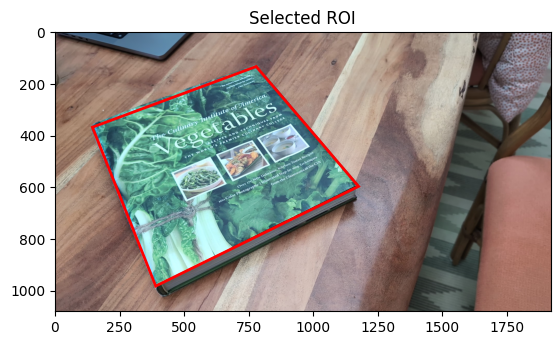

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your first frame as before
frame0 = load_single_frame(vidpath, 0)   # shape (H, W, 3), RGB in [0,1]

# Prepare for interactive picking
points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        # draw a small circle so you see your click
        cv2.circle(frame_disp, (x, y), 5, (0, 255, 0), -1)

# Convert to BGR uint8 for cv2 display
frame_disp = cv2.cvtColor((frame0 * 255).astype('uint8'), cv2.COLOR_RGB2BGR)
win = "Select 4 corners: TL → TR → BR → BL"
cv2.namedWindow(win)
cv2.setMouseCallback(win, mouse_callback)

print("Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).")

# Show window and wait until 4 clicks
while True:
    cv2.imshow(win, frame_disp)
    if len(points) == 4:
        break
    # small delay
    if cv2.waitKey(50) & 0xFF == 27:  # allow Esc to abort early
        break

cv2.destroyAllWindows()

# Convert collected (x,y) to (row, col) array
corners = np.array([[y, x] for (x, y) in points])  # shape (4,2)

print("Selected corners (row, col):")
print(corners)

# width = horizontal span (x‑axis = column index)
width  = int(max(abs(corners[1,1] - corners[0,1]),   # top edge
                 abs(corners[2,1] - corners[3,1])))  # bottom edge

# height = vertical span (y‑axis = row index)
height = int(max(abs(corners[3,0] - corners[0,0]),   # left edge
                 abs(corners[2,0] - corners[1,0])))  # right edge

rectcorners = np.array([[0, 0],
                        [0, width],
                        [height, width],
                        [height, 0]])


H0C, _ = cv2.findHomography(corners[:, ::-1],   # col,row order
                            rectcorners[:, ::-1],
                            cv2.RANSAC)

# visualize the region you picked
plt.imshow(frame0)
plt.fill(corners[:,1], corners[:,0],
         edgecolor='red', lw=2, facecolor='none')
plt.title("Selected ROI")
plt.show()


In [6]:
# Rectify Original Image
def rectify(img, incorners, outcorners):
  outsize = (outcorners[2, 1], outcorners[2, 0])
  H, m = cv2.findHomography(incorners[:,::-1], outcorners[:,::-1], cv2.RANSAC) # uses col,row order
  outimg = cv2.warpPerspective(img, H, outsize)
  return outimg

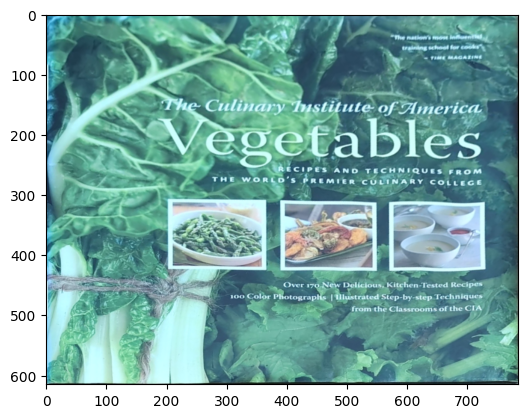

In [7]:
# show original rectified image
refimg = rectify(frame0, corners, rectcorners)
plt.imshow(refimg)
plt.show()

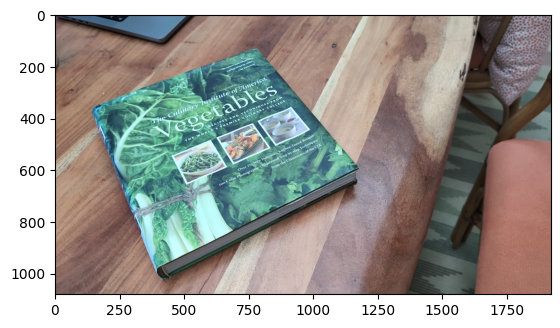

In [8]:
# load another frame
frame1 = load_single_frame(vidpath, 1)
plt.imshow(frame1)
plt.show()

In [9]:
def find_homography(img0, img1):
  gray0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
  gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

  orb = cv2.ORB_create(nfeatures=2000)
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  kp0, des0 = orb.detectAndCompute(gray0, None)
  kp1, des1 = orb.detectAndCompute(gray1, None)

  matches = bf.match(des0, des1)
  matches = sorted(matches, key = lambda x:x.distance)

  src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  des_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  H, m = cv2.findHomography(src_pts, des_pts, cv2.RANSAC, 5.0)

  return H

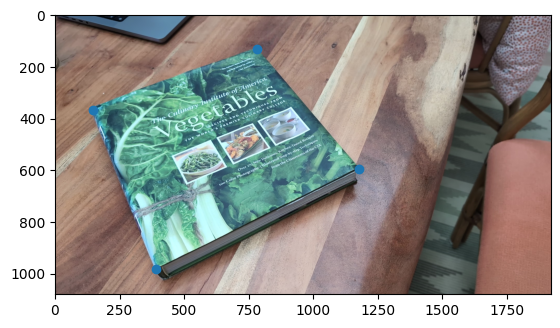

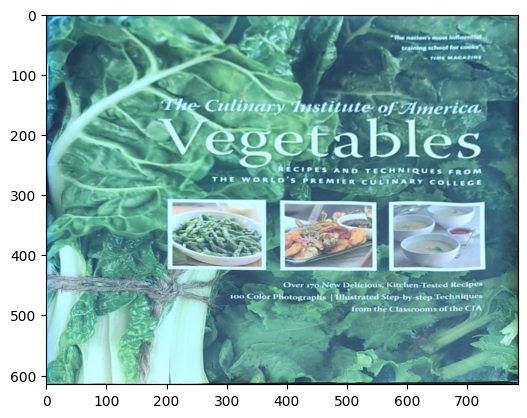

In [10]:
# warp new frame to rectified space
H = find_homography(refimg, frame1)

# change to both xy and column format
newcorners = cv2.perspectiveTransform(np.float32(rectcorners[:, ::-1].reshape(-1, 1, 2)), H)

# show new corners
plt.imshow(frame1)
plt.scatter(newcorners[:,:,0], newcorners[:,:,1])
plt.show()

# show rectified image
rectimg = rectify(frame1, newcorners, rectcorners)
plt.imshow(rectimg)
plt.show()

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


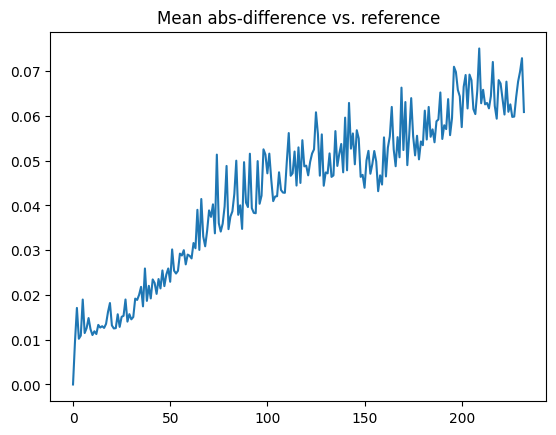

In [12]:
incr       = 1
frame_ixs  = range(0, 233, incr)
nframes    = len(frame_ixs)
error      = np.zeros(nframes)
imgs       = np.zeros([nframes, height, width, 3])

for i, fi in enumerate(frame_ixs):
    if i % 10 == 0:
        print('.')

    fimg  = load_single_frame(vidpath, fi)      # current frame
    H01   = find_homography(frame0, fimg)            # frame0 → current frame
    H1C   = H0C @ np.linalg.inv(H01)            # current frame → canonical

    rect  = cv2.warpPerspective(fimg, H1C, (width, height))
    error[i] = np.mean(np.abs(rect/255. - refimg/255.))
    imgs[i]  = rect

plt.plot(error)
plt.title("Mean abs‑difference vs. reference")
plt.show()

In [13]:
import imageio

In [14]:
with imageio.get_writer("recitified.gif", mode="I") as writer:
  for idx, frame in enumerate(imgs):
    print("Adding frame to GIF file: ", idx + 1)
    writer.append_data(np.uint8(frame))

Adding frame to GIF file:  1
Adding frame to GIF file:  2
Adding frame to GIF file:  3
Adding frame to GIF file:  4
Adding frame to GIF file:  5
Adding frame to GIF file:  6
Adding frame to GIF file:  7
Adding frame to GIF file:  8
Adding frame to GIF file:  9
Adding frame to GIF file:  10
Adding frame to GIF file:  11
Adding frame to GIF file:  12
Adding frame to GIF file:  13
Adding frame to GIF file:  14
Adding frame to GIF file:  15
Adding frame to GIF file:  16
Adding frame to GIF file:  17
Adding frame to GIF file:  18
Adding frame to GIF file:  19
Adding frame to GIF file:  20
Adding frame to GIF file:  21
Adding frame to GIF file:  22
Adding frame to GIF file:  23
Adding frame to GIF file:  24
Adding frame to GIF file:  25
Adding frame to GIF file:  26
Adding frame to GIF file:  27
Adding frame to GIF file:  28
Adding frame to GIF file:  29
Adding frame to GIF file:  30
Adding frame to GIF file:  31
Adding frame to GIF file:  32
Adding frame to GIF file:  33
Adding frame to GIF

In [ ]:
import cv2, numpy as np

height, width = imgs[0].shape[:2]
fps      = 30
out_path = "rectified_video.mp4"
fourcc   = cv2.VideoWriter_fourcc(*"mp4v")

writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

for idx, frame in enumerate(imgs):
    print(f"Writing frame {idx + 1}/{len(imgs)}")
    bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    writer.write(bgr)

writer.release()
print("✓  Video written to", out_path)


Writing frame 1/233
Writing frame 2/233
Writing frame 3/233
Writing frame 4/233
Writing frame 5/233
Writing frame 6/233
Writing frame 7/233
Writing frame 8/233
Writing frame 9/233
Writing frame 10/233
Writing frame 11/233
Writing frame 12/233
Writing frame 13/233
Writing frame 14/233
Writing frame 15/233
Writing frame 16/233
Writing frame 17/233
Writing frame 18/233
Writing frame 19/233
Writing frame 20/233
Writing frame 21/233
Writing frame 22/233
Writing frame 23/233
Writing frame 24/233
Writing frame 25/233
Writing frame 26/233
Writing frame 27/233
Writing frame 28/233
Writing frame 29/233
Writing frame 30/233
Writing frame 31/233
Writing frame 32/233
Writing frame 33/233
Writing frame 34/233
Writing frame 35/233
Writing frame 36/233
Writing frame 37/233
Writing frame 38/233
Writing frame 39/233
Writing frame 40/233
Writing frame 41/233
Writing frame 42/233
Writing frame 43/233
Writing frame 44/233
Writing frame 45/233
Writing frame 46/233
Writing frame 47/233
Writing frame 48/233
W

: 